# Creating H5Types definitions

In [1]:
!python3 ../scripts/make_h5types.py -c ../config/Microcircuit_Small.yaml --output-path datasets/MiV_Small_h5types.h5

numprocs=1


In [2]:
!h5ls -r ./datasets/MiV_Small_h5types.h5

/                        Group
/H5Types                 Group
/H5Types/Population\ labels Type
/H5Types/Population\ projections Type
/H5Types/Population\ range Type
/H5Types/Populations     Dataset {4}
/H5Types/Valid\ population\ projections Dataset {10}


In [4]:
!h5dump -d /H5Types/Populations ./datasets/MiV_Small_h5types.h5

HDF5 "./datasets/MiV_Small_h5types.h5" {
DATASET "/H5Types/Populations" {
   DATATYPE  H5T_COMPOUND {
      H5T_STD_U64LE "Start";
      H5T_STD_U32LE "Count";
      H5T_ENUM {
         H5T_STD_U16LE;
         "OLM"              102;
         "PVBC"             101;
         "PYR"              100;
         "STIM"             0;
      } "Population";
   }
   DATASPACE  SIMPLE { ( 4 ) / ( 4 ) }
   DATA {
   (0): {
         0,
         10,
         STIM
      },
   (1): {
         10,
         80,
         PYR
      },
   (2): {
         90,
         53,
         PVBC
      },
   (3): {
         143,
         44,
         OLM
      }
   }
}
}


# Copying and compiling NMODL mechanisms

In [4]:
!cp ../mechanisms/*.mod .

In [5]:
!~/bin/nrnpython3/bin/nrnivmodl .

/home/igr/src/model/MiV/notebooks
Mod files: "./ch_CavL.mod" "./ch_CavN.mod" "./ch_HCNolm.mod" "./ch_HCNp.mod" "./ch_KCaS.mod" "./ch_Kdrfast.mod" "./ch_Kdrp.mod" "./ch_KvAdistp.mod" "./ch_KvA.mod" "./ch_KvAolm.mod" "./ch_KvAproxp.mod" "./ch_KvCaB.mod" "./ch_leak.mod" "./ch_Navaxonp.mod" "./ch_Nav.mod" "./ch_Navp.mod"

COBJS=''
 -> Compiling mod_func.cpp
 -> NMODL .././ch_CavL.mod
 -> NMODL .././ch_CavN.mod
 -> NMODL .././ch_HCNolm.mod
Translating ch_CavL.mod into /home/igr/src/model/MiV/notebooks/x86_64/ch_CavL.c
Notice: VERBATIM blocks are not thread safe
Translating ch_HCNolm.mod into /home/igr/src/model/MiV/notebooks/x86_64/ch_HCNolm.c
Translating ch_CavN.mod into /home/igr/src/model/MiV/notebooks/x86_64/ch_CavN.c
Notice: VERBATIM blocks are not thread safe
Notice: Assignment to the GLOBAL variable, "rexp", is not thread safe
Notice: Assignment to the GLOBAL variable, "rinf", is not thread safe
Notice: Assignment to the GLOBAL variable, "tau_r", is not thread safe
 -> NMODL .././ch_

# Generating soma coordinates and measuring distances

In [5]:
!python3 ../scripts/generate_soma_coordinates.py -v \
    --config=Microcircuit_Small.yaml --config-prefix=../config \
    --types-path=./datasets/MiV_Small_h5types.h5 \
    --output-path=./datasets/Microcircuit_Small_coords.h5 \
    --output-namespace='Generated Coordinates' 


numprocs=1
INFO:CA1.generate_soma_coordinates.py:1 ranks have been allocated
INFO:CA1:env.dataset_prefix = None
INFO:CA1:env.cell_selection_path = None
INFO:CA1.generate_soma_coordinates.py:Constructing alpha shape for volume: extents: ((0.0, 1000.0), (0.0, 1000.0), (0.0, 450.0))...
INFO:neural_geometry.geometry:Constructing volume triangulation...
INFO:neural_geometry.geometry:Constructing alpha shape...
INFO:CA1.generate_soma_coordinates.py:Constructing alpha shape for layers SO: extents: [[0.0, 0.0, 0.0], [1000.0, 1000.0, 100.0]]...
INFO:neural_geometry.geometry:Constructing volume triangulation...
INFO:neural_geometry.geometry:Constructing alpha shape...
INFO:CA1.generate_soma_coordinates.py:Constructing alpha shape for layers SP: extents: [[0.0, 0.0, 100.0], [1000.0, 1000.0, 150.0]]...
INFO:neural_geometry.geometry:Constructing volume triangulation...
INFO:neural_geometry.geometry:Constructing alpha shape...
INFO:CA1.generate_soma_coordinates.py:Constructing alpha shape for layers

In [1]:
!mpirun.mpich -n 8 python3 ../scripts/measure_distances.py -v \
             -i PYR -i PVBC -i OLM -i STIM \
             --config=../config/Microcircuit_Small.yaml \
             --coords-path=./datasets/Microcircuit_Small_coords.h5 

numprocs=8
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.../scripts/measure_distances.py:Reading population coordinates...
INFO:MiV.../scripts/measure_distances.py:Creating distance interpolant...
INFO:neural_geometry.geometry:Creating volume: min_l = 0.000000 max_l = 450.000000...
INFO:neural_geometry.geometry:Computing reference distances...
INFO:neural_geometry.geometry:Origin coordinates: 500.000000 500.000000 450.010000
INFO:neural_geometry.geometry:Origin position: 0.500000 0.500000 extent: 1000.020000 1000.020000
INFO:neural_geometry.geometry:Origin ranges: -500.010000 : 500.010000 -500.010000 : 500.010000
INFO:neural_geometry.geometry:Creating volume triangulation...
INFO:neural_geometry.geometry:Constructing alpha shape...
INFO:neural_geometry.geometry:Generating 2000 nodes (20 iterations)...
INFO:neural_geometry.geometry:1692 interior nodes generated (20 iterations)
INFO:neural_geometry.geometry:Inverse interpolation of UVL coordinates...

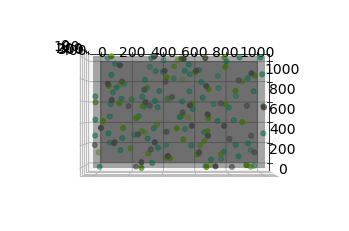

In [2]:
%run ../scripts/plot_coords_in_volume.py \
--config ../config/Microcircuit_Small.yaml \
--coords-path datasets/Microcircuit_Small_coords.h5 \
-i PYR -i PVBC -i OLM

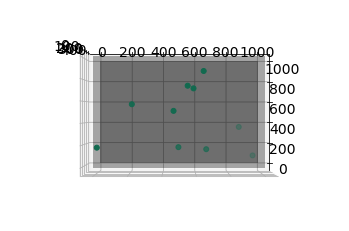

In [3]:
%run ../scripts/plot_coords_in_volume.py \
--config ../config/Microcircuit_Small.yaml \
--coords-path datasets/Microcircuit_Small_coords.h5 \
-i STIM

# Distributing synapses along dendritic trees

In [12]:
!~/src/neuroh5/bin/neurotrees_copy --fill --output datasets/PYR_forest_Small.h5 datasets/PYR_tree.h5 PYR 10

Task 0: Population name is PYR
Task 0: Input file name is datasets/PYR_tree.h5
Task 0: Output file name is datasets/PYR_forest_Small.h5
Task 0: Source id is 10
Task 0: Output local id 10 (global id 10)
Task 0: Output local id 11 (global id 11)
Task 0: Output local id 12 (global id 12)
Task 0: Output local id 13 (global id 13)
Task 0: Output local id 14 (global id 14)
Task 0: Output local id 15 (global id 15)
Task 0: Output local id 16 (global id 16)
Task 0: Output local id 17 (global id 17)
Task 0: Output local id 18 (global id 18)
Task 0: Output local id 19 (global id 19)
Task 0: Output local id 20 (global id 20)
Task 0: Output local id 21 (global id 21)
Task 0: Output local id 22 (global id 22)
Task 0: Output local id 23 (global id 23)
Task 0: Output local id 24 (global id 24)
Task 0: Output local id 25 (global id 25)
Task 0: Output local id 26 (global id 26)
Task 0: Output local id 27 (global id 27)
Task 0: Output local id 28 (global id 28)
Task 0: Output local id 29 (global id 29)


In [8]:
!~/src/neuroh5/bin/neurotrees_copy --fill --output datasets/PVBC_forest_Small.h5 datasets/PVBC_tree.h5 PVBC 90

Task 0: Population name is PVBC
Task 0: Input file name is datasets/PVBC_tree.h5
Task 0: Output file name is datasets/PVBC_forest_Small.h5
Task 0: Source id is 90
Task 0: Output local id 90 (global id 90)
Task 0: Output local id 91 (global id 91)
Task 0: Output local id 92 (global id 92)
Task 0: Output local id 93 (global id 93)
Task 0: Output local id 94 (global id 94)
Task 0: Output local id 95 (global id 95)
Task 0: Output local id 96 (global id 96)
Task 0: Output local id 97 (global id 97)
Task 0: Output local id 98 (global id 98)
Task 0: Output local id 99 (global id 99)
Task 0: Output local id 100 (global id 100)
Task 0: Output local id 101 (global id 101)
Task 0: Output local id 102 (global id 102)
Task 0: Output local id 103 (global id 103)
Task 0: Output local id 104 (global id 104)
Task 0: Output local id 105 (global id 105)
Task 0: Output local id 106 (global id 106)
Task 0: Output local id 107 (global id 107)
Task 0: Output local id 108 (global id 108)
Task 0: Output local 

In [9]:
!~/src/neuroh5/bin/neurotrees_copy --fill --output datasets/OLM_forest_Small.h5 datasets/OLM_tree.h5 OLM 143

Task 0: Population name is OLM
Task 0: Input file name is datasets/OLM_tree.h5
Task 0: Output file name is datasets/OLM_forest_Small.h5
Task 0: Source id is 143
Task 0: Output local id 143 (global id 143)
Task 0: Output local id 144 (global id 144)
Task 0: Output local id 145 (global id 145)
Task 0: Output local id 146 (global id 146)
Task 0: Output local id 147 (global id 147)
Task 0: Output local id 148 (global id 148)
Task 0: Output local id 149 (global id 149)
Task 0: Output local id 150 (global id 150)
Task 0: Output local id 151 (global id 151)
Task 0: Output local id 152 (global id 152)
Task 0: Output local id 153 (global id 153)
Task 0: Output local id 154 (global id 154)
Task 0: Output local id 155 (global id 155)
Task 0: Output local id 156 (global id 156)
Task 0: Output local id 157 (global id 157)
Task 0: Output local id 158 (global id 158)
Task 0: Output local id 159 (global id 159)
Task 0: Output local id 160 (global id 160)
Task 0: Output local id 161 (global id 161)
Tas

In [13]:
!mpirun.mpich -n 1 python3 ../scripts/distribute_synapse_locs.py \
             --template-path ../templates \
             --config-prefix ../config \
              --config=Microcircuit.yaml \
              --populations PYR \
              --forest-path=./datasets/PYR_forest_Small.h5 \
              --output-path=./datasets/PYR_forest_Small.h5 \
              --distribution=poisson \
              --io-size=1 --write-size=0 -v

numprocs=1
INFO:MiV.distribute_synapse_locs.py:1 ranks have been allocated
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.distribute_synapse_locs.py:Rank 0 population: PYR
INFO:MiV.neuron_utils:Loaded PoolosPyramidalCell from ../templates/PoolosPyramidalCell.hoc
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.99 s to compute 33275 synapse locations for PYR gid: 89
layer 8: excitatory synapses: 5549
layer 8: inhibitory synapses: 395
layer 9: excitatory synapses: 16220
layer 9: inhibitory synapses: 553
layer 5: excitatory synapses: 10079
layer 5: inhibitory synapses: 418
layer 6: excitatory synapses: 14
layer 6: inhibitory synapses: 47
swc_type 4: excitatory synapses: 21769
swc_type 4: inhibitory synapses: 776
swc_type 3: excitatory synapses: 10079
swc_type 3: inhibitory synapses: 418
swc_type 1: excitatory synapses: 14
swc_type 1: inhibitory synapses: 13
swc_type 7: excitatory synapses: 0
swc_type 7: inhibitory synapses: 206
INFO:MiV.distribute_syn

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.96 s to compute 33635 synapse locations for PYR gid: 77
layer 8: excitatory synapses: 5576
layer 8: inhibitory synapses: 470
layer 9: excitatory synapses: 16344
layer 9: inhibitory synapses: 632
layer 5: excitatory synapses: 10186
layer 5: inhibitory synapses: 354
layer 6: excitatory synapses: 14
layer 6: inhibitory synapses: 59
swc_type 4: excitatory synapses: 21920
swc_type 4: inhibitory synapses: 924
swc_type 3: excitatory synapses: 10186
swc_type 3: inhibitory synapses: 354
swc_type 1: excitatory synapses: 14
swc_type 1: inhibitory synapses: 18
swc_type 7: excitatory synapses: 0
swc_type 7: inhibitory synapses: 219
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.97 s to compute 33459 synapse locations for PYR gid: 76
layer 8: excitatory synapses: 5531
layer 8: inhibitory synapses: 386
layer 9: excitatory synapses: 16275
layer 9: inhibitory synapses: 630
layer 5: excitatory synapses: 10101
layer 5: inhibitory synapses: 469
layer 6:

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.98 s to compute 33451 synapse locations for PYR gid: 64
layer 8: excitatory synapses: 5494
layer 8: inhibitory synapses: 403
layer 9: excitatory synapses: 16423
layer 9: inhibitory synapses: 609
layer 5: excitatory synapses: 10023
layer 5: inhibitory synapses: 441
layer 6: excitatory synapses: 14
layer 6: inhibitory synapses: 44
swc_type 4: excitatory synapses: 21917
swc_type 4: inhibitory synapses: 855
swc_type 3: excitatory synapses: 10023
swc_type 3: inhibitory synapses: 441
swc_type 1: excitatory synapses: 14
swc_type 1: inhibitory synapses: 13
swc_type 7: excitatory synapses: 0
swc_type 7: inhibitory synapses: 188
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 1.00 s to compute 33977 synapse locations for PYR gid: 63
layer 8: excitatory synapses: 5638
layer 8: inhibitory synapses: 357
layer 9: excitatory synapses: 16657
layer 9: inhibitory synapses: 718
layer 5: excitatory synapses: 10101
layer 5: inhibitory synapses: 443
layer 6:

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.96 s to compute 33339 synapse locations for PYR gid: 51
layer 8: excitatory synapses: 5445
layer 8: inhibitory synapses: 304
layer 9: excitatory synapses: 16323
layer 9: inhibitory synapses: 665
layer 5: excitatory synapses: 10054
layer 5: inhibitory synapses: 495
layer 6: excitatory synapses: 13
layer 6: inhibitory synapses: 40
swc_type 4: excitatory synapses: 21768
swc_type 4: inhibitory synapses: 777
swc_type 3: excitatory synapses: 10054
swc_type 3: inhibitory synapses: 495
swc_type 1: excitatory synapses: 13
swc_type 1: inhibitory synapses: 14
swc_type 7: excitatory synapses: 0
swc_type 7: inhibitory synapses: 218
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 1.00 s to compute 33565 synapse locations for PYR gid: 50
layer 8: excitatory synapses: 5490
layer 8: inhibitory synapses: 451
layer 9: excitatory synapses: 16547
layer 9: inhibitory synapses: 547
layer 5: excitatory synapses: 10010
layer 5: inhibitory synapses: 459
layer 6:

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.97 s to compute 33593 synapse locations for PYR gid: 38
layer 8: excitatory synapses: 5384
layer 8: inhibitory synapses: 424
layer 9: excitatory synapses: 16445
layer 9: inhibitory synapses: 622
layer 5: excitatory synapses: 10174
layer 5: inhibitory synapses: 472
layer 6: excitatory synapses: 14
layer 6: inhibitory synapses: 58
swc_type 4: excitatory synapses: 21829
swc_type 4: inhibitory synapses: 876
swc_type 3: excitatory synapses: 10174
swc_type 3: inhibitory synapses: 472
swc_type 1: excitatory synapses: 14
swc_type 1: inhibitory synapses: 13
swc_type 7: excitatory synapses: 0
swc_type 7: inhibitory synapses: 215
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.98 s to compute 33538 synapse locations for PYR gid: 37
layer 8: excitatory synapses: 5526
layer 8: inhibitory synapses: 290
layer 9: excitatory synapses: 16350
layer 9: inhibitory synapses: 592
layer 5: excitatory synapses: 10327
layer 5: inhibitory synapses: 390
layer 6:

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.96 s to compute 33048 synapse locations for PYR gid: 25
layer 8: excitatory synapses: 5460
layer 8: inhibitory synapses: 354
layer 9: excitatory synapses: 16139
layer 9: inhibitory synapses: 718
layer 5: excitatory synapses: 9944
layer 5: inhibitory synapses: 384
layer 6: excitatory synapses: 13
layer 6: inhibitory synapses: 36
swc_type 4: excitatory synapses: 21599
swc_type 4: inhibitory synapses: 905
swc_type 3: excitatory synapses: 9944
swc_type 3: inhibitory synapses: 384
swc_type 1: excitatory synapses: 13
swc_type 1: inhibitory synapses: 13
swc_type 7: excitatory synapses: 0
swc_type 7: inhibitory synapses: 190
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.96 s to compute 33479 synapse locations for PYR gid: 24
layer 8: excitatory synapses: 5473
layer 8: inhibitory synapses: 381
layer 9: excitatory synapses: 16653
layer 9: inhibitory synapses: 563
layer 5: excitatory synapses: 9927
layer 5: inhibitory synapses: 427
layer 6: ex

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.97 s to compute 33406 synapse locations for PYR gid: 12
layer 8: excitatory synapses: 5396
layer 8: inhibitory synapses: 465
layer 9: excitatory synapses: 16359
layer 9: inhibitory synapses: 585
layer 5: excitatory synapses: 10140
layer 5: inhibitory synapses: 403
layer 6: excitatory synapses: 13
layer 6: inhibitory synapses: 45
swc_type 4: excitatory synapses: 21755
swc_type 4: inhibitory synapses: 899
swc_type 3: excitatory synapses: 10140
swc_type 3: inhibitory synapses: 403
swc_type 1: excitatory synapses: 13
swc_type 1: inhibitory synapses: 13
swc_type 7: excitatory synapses: 0
swc_type 7: inhibitory synapses: 183
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.98 s to compute 33690 synapse locations for PYR gid: 11
layer 8: excitatory synapses: 5375
layer 8: inhibitory synapses: 372
layer 9: excitatory synapses: 16572
layer 9: inhibitory synapses: 707
layer 5: excitatory synapses: 10085
layer 5: inhibitory synapses: 519
layer 6:

In [14]:
!mpirun.mpich -n 1 python3 ../scripts/distribute_synapse_locs.py \
             --template-path ../templates \
             --config-prefix ../config \
              --config=Microcircuit.yaml \
              --populations PVBC \
              --forest-path=./datasets/PVBC_forest_Small.h5 \
              --output-path=./datasets/PVBC_forest_Small.h5 \
              --distribution=poisson \
              --io-size=1 --write-size=0 -v

numprocs=1
INFO:MiV.distribute_synapse_locs.py:1 ranks have been allocated
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.distribute_synapse_locs.py:Rank 0 population: PVBC
INFO:MiV.neuron_utils:Loaded PVBasketCell from ../templates/PVBasketCell.hoc
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.21 s to compute 8361 synapse locations for PVBC gid: 142
layer 8: excitatory synapses: 1107
layer 8: inhibitory synapses: 60
layer 9: excitatory synapses: 2814
layer 9: inhibitory synapses: 104
layer 5: excitatory synapses: 2193
layer 5: inhibitory synapses: 2069
layer 6: excitatory synapses: 10
layer 6: inhibitory synapses: 4
swc_type 4: excitatory synapses: 3921
swc_type 4: inhibitory synapses: 164
swc_type 3: excitatory synapses: 2193
swc_type 3: inhibitory synapses: 2069
swc_type 1: excitatory synapses: 10
swc_type 1: inhibitory synapses: 4
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.21 s to compute 8156 synapse locations for PVBC gid: 141
layer

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.21 s to compute 8134 synapse locations for PVBC gid: 128
layer 8: excitatory synapses: 1071
layer 8: inhibitory synapses: 35
layer 9: excitatory synapses: 2741
layer 9: inhibitory synapses: 91
layer 5: excitatory synapses: 2166
layer 5: inhibitory synapses: 2014
layer 6: excitatory synapses: 9
layer 6: inhibitory synapses: 7
swc_type 4: excitatory synapses: 3812
swc_type 4: inhibitory synapses: 126
swc_type 3: excitatory synapses: 2166
swc_type 3: inhibitory synapses: 2014
swc_type 1: excitatory synapses: 9
swc_type 1: inhibitory synapses: 7
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.21 s to compute 8153 synapse locations for PVBC gid: 127
layer 8: excitatory synapses: 1105
layer 8: inhibitory synapses: 37
layer 9: excitatory synapses: 2720
layer 9: inhibitory synapses: 80
layer 5: excitatory synapses: 2132
layer 5: inhibitory synapses: 2067
layer 6: excitatory synapses: 5
layer 6: inhibitory synapses: 7
swc_type 4: excitatory sy

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.21 s to compute 8283 synapse locations for PVBC gid: 114
layer 8: excitatory synapses: 1162
layer 8: inhibitory synapses: 37
layer 9: excitatory synapses: 2753
layer 9: inhibitory synapses: 112
layer 5: excitatory synapses: 2135
layer 5: inhibitory synapses: 2071
layer 6: excitatory synapses: 8
layer 6: inhibitory synapses: 5
swc_type 4: excitatory synapses: 3915
swc_type 4: inhibitory synapses: 149
swc_type 3: excitatory synapses: 2135
swc_type 3: inhibitory synapses: 2071
swc_type 1: excitatory synapses: 8
swc_type 1: inhibitory synapses: 5
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.21 s to compute 8091 synapse locations for PVBC gid: 113
layer 8: excitatory synapses: 1091
layer 8: inhibitory synapses: 27
layer 9: excitatory synapses: 2720
layer 9: inhibitory synapses: 102
layer 5: excitatory synapses: 2156
layer 5: inhibitory synapses: 1979
layer 6: excitatory synapses: 11
layer 6: inhibitory synapses: 5
swc_type 4: excitatory

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.21 s to compute 8247 synapse locations for PVBC gid: 100
layer 8: excitatory synapses: 1141
layer 8: inhibitory synapses: 27
layer 9: excitatory synapses: 2780
layer 9: inhibitory synapses: 86
layer 5: excitatory synapses: 2129
layer 5: inhibitory synapses: 2068
layer 6: excitatory synapses: 6
layer 6: inhibitory synapses: 10
swc_type 4: excitatory synapses: 3921
swc_type 4: inhibitory synapses: 113
swc_type 3: excitatory synapses: 2129
swc_type 3: inhibitory synapses: 2068
swc_type 1: excitatory synapses: 6
swc_type 1: inhibitory synapses: 10
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.21 s to compute 8176 synapse locations for PVBC gid: 99
layer 8: excitatory synapses: 1066
layer 8: inhibitory synapses: 39
layer 9: excitatory synapses: 2698
layer 9: inhibitory synapses: 96
layer 5: excitatory synapses: 2210
layer 5: inhibitory synapses: 2059
layer 6: excitatory synapses: 5
layer 6: inhibitory synapses: 3
swc_type 4: excitatory s

In [15]:
!mpirun.mpich -n 1 python3 ../scripts/distribute_synapse_locs.py \
             --template-path ../templates \
             --config-prefix ../config \
              --config=Microcircuit.yaml \
              --populations OLM \
              --forest-path=./datasets/OLM_forest_Small.h5 \
              --output-path=./datasets/OLM_forest_Small.h5 \
              --distribution=poisson \
              --io-size=1 --write-size=0 -v

numprocs=1
INFO:MiV.distribute_synapse_locs.py:1 ranks have been allocated
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.distribute_synapse_locs.py:Rank 0 population: OLM
INFO:MiV.neuron_utils:Loaded OLMCell from ../templates/OLMCell.hoc
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.09 s to compute 3655 synapse locations for OLM gid: 186
layer 5: excitatory synapses: 2843
layer 5: inhibitory synapses: 812
swc_type 3: excitatory synapses: 2843
swc_type 3: inhibitory synapses: 812
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.09 s to compute 3698 synapse locations for OLM gid: 185
layer 5: excitatory synapses: 2900
layer 5: inhibitory synapses: 798
swc_type 3: excitatory synapses: 2900
swc_type 3: inhibitory synapses: 798
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.09 s to compute 3580 synapse locations for OLM gid: 184
layer 5: excitatory synapses: 2752
layer 5: inhibitory synapses: 828
swc_type 3: excitatory synapses: 2752
swc_type 3:

INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.09 s to compute 3721 synapse locations for OLM gid: 154
layer 5: excitatory synapses: 2880
layer 5: inhibitory synapses: 841
swc_type 3: excitatory synapses: 2880
swc_type 3: inhibitory synapses: 841
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.09 s to compute 3606 synapse locations for OLM gid: 153
layer 5: excitatory synapses: 2759
layer 5: inhibitory synapses: 847
swc_type 3: excitatory synapses: 2759
swc_type 3: inhibitory synapses: 847
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.09 s to compute 3700 synapse locations for OLM gid: 152
layer 5: excitatory synapses: 2846
layer 5: inhibitory synapses: 854
swc_type 3: excitatory synapses: 2846
swc_type 3: inhibitory synapses: 854
INFO:MiV.distribute_synapse_locs.py:Rank 0 took 0.09 s to compute 3694 synapse locations for OLM gid: 151
layer 5: excitatory synapses: 2870
layer 5: inhibitory synapses: 824
swc_type 3: excitatory synapses: 2870
swc_type 3: inhibitory synapses: 824


# Generating connections

In [16]:
!mpirun.mpich -n 8 python3 ../scripts/generate_distance_connections.py \
    --config-prefix=../config \
    --config=Microcircuit_Small.yaml \
    --forest-path=datasets/PYR_forest_Small.h5 \
    --connectivity-path=datasets/Microcircuit_Small_connections.h5 \
    --connectivity-namespace=Connections \
    --coords-path=datasets/Microcircuit_Small_coords.h5 \
    --coords-namespace='Generated Coordinates' \
    --io-size=1 --cache-size=20 --write-size=100 -v

numprocs=8
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.generate_distance_connections.py:Reading OLM coordinates...
INFO:MiV.generate_distance_connections.py:Reading PVBC coordinates...
INFO:MiV.generate_distance_connections.py:Reading PYR coordinates...
INFO:MiV.generate_distance_connections.py:Reading STIM coordinates...
INFO:MiV.generate_distance_connections.py:Generating connectivity for populations ['PYR']...
INFO:MiV.generate_distance_connections.py:Generating connection probabilities for population PYR...
INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_fac

INFO:MiV.connections:Rank 4 took 2.51 s to compute 33302 edges for destination: PYR, gid: 14
INFO:MiV.connections:Rank 0 took 2.57 s to compute 33618 edges for destination: PYR, gid: 10
INFO:MiV.connections:Rank 2 took 2.63 s to compute 33406 edges for destination: PYR, gid: 12
INFO:MiV.connections:Rank 5 took 2.64 s to compute 33446 edges for destination: PYR, gid: 15
INFO:MiV.connections:Rank 1 took 4.08 s to compute 33690 edges for destination: PYR, gid: 11
INFO:MiV.connections:Rank 3 took 4.08 s to compute 33453 edges for destination: PYR, gid: 13
INFO:MiV.connections:Rank 6 took 4.11 s to compute 33631 edges for destination: PYR, gid: 16
INFO:MiV.connections:Rank 7 took 4.13 s to compute 33993 edges for destination: PYR, gid: 17
Rank 0: append_graph: OLM -> PYR:  total_num_nodes = 8






Rank 1: append_graph: OLM -> PYR:  total_num_nodes = 8






Rank 2: append_graph: OLM -> PYR:  total_num_nodes = 8






Rank 3: append_graph: OLM -> PYR:  total_num_nodes = 8






Rank 4: appe

INFO:MiV.connections:Rank 7 took 4.39 s to compute 33048 edges for destination: PYR, gid: 25
INFO:MiV.connections:Rank 7 received attributes for destination: PYR, gid: 33
INFO:MiV.connections:Rank 3 took 4.46 s to compute 33535 edges for destination: PYR, gid: 21
INFO:MiV.connections:Rank 3 received attributes for destination: PYR, gid: 29
INFO:MiV.connections:Rank 6 took 4.47 s to compute 33479 edges for destination: PYR, gid: 24
INFO:MiV.connections:Rank 6 received attributes for destination: PYR, gid: 32
INFO:MiV.connections:Rank 1 took 4.50 s to compute 33881 edges for destination: PYR, gid: 19
INFO:MiV.connections:Rank 1 received attributes for destination: PYR, gid: 27
INFO:MiV.connections:Rank 0 took 2.76 s to compute 33110 edges for destination: PYR, gid: 26
INFO:MiV.connections:Rank 0 received attributes for destination: PYR, gid: 34
INFO:MiV.connections:Rank 0 has 15 possible sources from population OLM for destination: PYR, layer 5, gid: 34; max U distance: 417.97 min U dist

INFO:MiV.connections:Rank 2 took 3.55 s to compute 33172 edges for destination: PYR, gid: 44
INFO:MiV.connections:Rank 2 received attributes for destination: PYR, gid: 52
INFO:MiV.connections:Rank 6 took 4.46 s to compute 33424 edges for destination: PYR, gid: 40
INFO:MiV.connections:Rank 6 received attributes for destination: PYR, gid: 48
INFO:MiV.connections:Rank 7 took 4.58 s to compute 33612 edges for destination: PYR, gid: 41
INFO:MiV.connections:Rank 7 received attributes for destination: PYR, gid: 49
INFO:MiV.connections:Rank 3 took 2.93 s to compute 33290 edges for destination: PYR, gid: 45
INFO:MiV.connections:Rank 3 received attributes for destination: PYR, gid: 53
INFO:MiV.connections:Rank 1 took 3.36 s to compute 33303 edges for destination: PYR, gid: 43
INFO:MiV.connections:Rank 1 received attributes for destination: PYR, gid: 51
INFO:MiV.connections:Rank 0 took 2.88 s to compute 33565 edges for destination: PYR, gid: 50
INFO:MiV.connections:Rank 0 received attributes for 

INFO:MiV.connections:Rank 1 took 3.37 s to compute 33315 edges for destination: PYR, gid: 59
INFO:MiV.connections:Rank 1 received attributes for destination: PYR, gid: 67
INFO:MiV.connections:Rank 4 took 4.67 s to compute 33833 edges for destination: PYR, gid: 54
INFO:MiV.connections:Rank 4 received attributes for destination: PYR, gid: 62
INFO:MiV.connections:Rank 5 took 4.66 s to compute 33628 edges for destination: PYR, gid: 55
INFO:MiV.connections:Rank 5 received attributes for destination: PYR, gid: 63
INFO:MiV.connections:Rank 2 took 2.99 s to compute 33934 edges for destination: PYR, gid: 68
INFO:MiV.connections:Rank 2 received attributes for destination: PYR, gid: 76
INFO:MiV.connections:Rank 6 took 4.57 s to compute 33511 edges for destination: PYR, gid: 56
INFO:MiV.connections:Rank 6 received attributes for destination: PYR, gid: 64
INFO:MiV.connections:Rank 7 took 4.54 s to compute 33117 edges for destination: PYR, gid: 57
INFO:MiV.connections:Rank 7 received attributes for 

Rank 0: append_projection: PYR -> PYR:  total_num_dests = 72






Rank 0: append_graph: STIM -> PYR:  total_num_nodes = 72






Rank 1: append_graph: STIM -> PYR:  total_num_nodes = 72






Rank 2: append_graph: STIM -> PYR:  total_num_nodes = 72






Rank 3: append_graph: STIM -> PYR:  total_num_nodes = 72






Rank 4: append_graph: STIM -> PYR:  total_num_nodes = 72






Rank 5: append_graph: STIM -> PYR:  total_num_nodes = 72






Rank 6: append_graph: STIM -> PYR:  total_num_nodes = 72






Rank 7: append_graph: STIM -> PYR:  total_num_nodes = 72






Rank 0: append_projection: STIM -> PYR:  total_num_dests = 72






INFO:MiV.connections:Appending connectivity for 4 projections took 0.24 s
INFO:MiV.connections:8 ranks took 45.97 s to generate 2680232 edges


In [17]:
!mpirun.mpich -n 8 python3 ../scripts/generate_distance_connections.py \
    --config-prefix=../config \
    --config=Microcircuit_Small.yaml \
    --forest-path=datasets/PVBC_forest_Small.h5 \
    --connectivity-path=datasets/Microcircuit_Small_connections.h5 \
    --connectivity-namespace=Connections \
    --coords-path=datasets/Microcircuit_Small_coords.h5 \
    --coords-namespace='Generated Coordinates' \
    --io-size=1 --cache-size=20 --write-size=100 -v

numprocs=8
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.generate_distance_connections.py:Reading OLM coordinates...
INFO:MiV.generate_distance_connections.py:Reading PVBC coordinates...
INFO:MiV.generate_distance_connections.py:Reading PYR coordinates...
INFO:MiV.generate_distance_connections.py:Reading STIM coordinates...
INFO:MiV.generate_distance_connections.py:Generating connectivity for populations ['PVBC']...
INFO:MiV.generate_distance_connections.py:Generating connection probabilities for population PVBC...
INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_f

INFO:MiV.connections:Rank 5 took 0.53 s to compute 8250 edges for destination: PVBC, gid: 95
INFO:MiV.connections:Rank 2 took 0.53 s to compute 8195 edges for destination: PVBC, gid: 92
INFO:MiV.connections:Rank 1 took 0.82 s to compute 8081 edges for destination: PVBC, gid: 91
INFO:MiV.connections:Rank 4 took 0.82 s to compute 8234 edges for destination: PVBC, gid: 94
INFO:MiV.connections:Rank 0 took 0.82 s to compute 8234 edges for destination: PVBC, gid: 90
INFO:MiV.connections:Rank 7 took 0.83 s to compute 8093 edges for destination: PVBC, gid: 97
INFO:MiV.connections:Rank 6 took 0.84 s to compute 8207 edges for destination: PVBC, gid: 96
INFO:MiV.connections:Rank 3 took 0.84 s to compute 8303 edges for destination: PVBC, gid: 93
Rank 0: append_graph: OLM -> PVBC:  total_num_nodes = 8






Rank 1: append_graph: OLM -> PVBC:  total_num_nodes = 8






Rank 2: append_graph: OLM -> PVBC:  total_num_nodes = 8






Rank 3: append_graph: OLM -> PVBC:  total_num_nodes = 8






Rank 4: 

INFO:MiV.connections:Rank 5 took 0.56 s to compute 8176 edges for destination: PVBC, gid: 111
INFO:MiV.connections:Rank 5 received attributes for destination: PVBC, gid: 119
INFO:MiV.connections:Rank 2 took 0.60 s to compute 8299 edges for destination: PVBC, gid: 108
INFO:MiV.connections:Rank 2 received attributes for destination: PVBC, gid: 116
INFO:MiV.connections:Rank 5 took 0.57 s to compute 8240 edges for destination: PVBC, gid: 119
INFO:MiV.connections:Rank 5 received attributes for destination: PVBC, gid: 127
INFO:MiV.connections:Rank 1 took 0.88 s to compute 8070 edges for destination: PVBC, gid: 107
INFO:MiV.connections:Rank 1 received attributes for destination: PVBC, gid: 115
INFO:MiV.connections:Rank 2 took 0.60 s to compute 8327 edges for destination: PVBC, gid: 116
INFO:MiV.connections:Rank 2 received attributes for destination: PVBC, gid: 124
INFO:MiV.connections:Rank 3 took 0.88 s to compute 8113 edges for destination: PVBC, gid: 109
INFO:MiV.connections:Rank 0 took 0.8

INFO:MiV.connections:Rank 6 received attributes for destination: PVBC, gid: 136
INFO:MiV.connections:Rank 4 took 0.94 s to compute 8188 edges for destination: PVBC, gid: 126
INFO:MiV.connections:Rank 4 received attributes for destination: PVBC, gid: 134
INFO:MiV.connections:Rank 0 has 45 possible sources from population PYR for destination: PVBC, layer 6, gid: 130; max U distance: 489.89 min U distance: 0.05
INFO:MiV.connections:Rank 0 has 45 possible sources from population PYR for destination: PVBC, layer 9, gid: 130; max U distance: 489.89 min U distance: 0.05
INFO:MiV.connections:Rank 0 has 45 possible sources from population PYR for destination: PVBC, layer 8, gid: 130; max U distance: 489.89 min U distance: 0.05
INFO:MiV.connections:Rank 0 has 45 possible sources from population PYR for destination: PVBC, layer 5, gid: 130; max U distance: 489.89 min U distance: 0.05
INFO:MiV.connections:Rank 0 has 5 possible sources from population STIM for destination: PVBC, layer 6, gid: 130; 

In [18]:
!mpirun.mpich -n 8 python3 ../scripts/generate_distance_connections.py \
    --config-prefix=../config \
    --config=Microcircuit_Small.yaml \
    --forest-path=datasets/OLM_forest_Small.h5 \
    --connectivity-path=datasets/Microcircuit_Small_connections.h5 \
    --connectivity-namespace=Connections \
    --coords-path=datasets/Microcircuit_Small_coords.h5 \
    --coords-namespace='Generated Coordinates' \
    --io-size=1 --cache-size=20 --write-size=100 -v

numprocs=8
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.generate_distance_connections.py:Reading OLM coordinates...
INFO:MiV.generate_distance_connections.py:Reading PVBC coordinates...
INFO:MiV.generate_distance_connections.py:Reading PYR coordinates...
INFO:MiV.generate_distance_connections.py:Reading STIM coordinates...
INFO:MiV.generate_distance_connections.py:Generating connectivity for populations ['OLM']...
INFO:MiV.generate_distance_connections.py:Generating connection probabilities for population OLM...
INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_factor: 166.66666666666666

INFO:MiV.connections:population STIM: layer: default: 
u width: 500.0
v width: 500.0
u scale_factor: 166.66666666666666
v scale_fac

INFO:MiV.connections:Rank 6 received attributes for destination: OLM, gid: 157
INFO:MiV.connections:Rank 3 received attributes for destination: OLM, gid: 154
INFO:MiV.connections:Rank 2 received attributes for destination: OLM, gid: 153
INFO:MiV.connections:Rank 0 received attributes for destination: OLM, gid: 151
INFO:MiV.connections:Rank 4 received attributes for destination: OLM, gid: 155
INFO:MiV.connections:Rank 7 received attributes for destination: OLM, gid: 158
INFO:MiV.connections:Rank 1 received attributes for destination: OLM, gid: 152
INFO:MiV.connections:Rank 5 received attributes for destination: OLM, gid: 156
INFO:MiV.connections:Rank 0 has 18 possible sources from population PVBC for destination: OLM, layer 5, gid: 151; max U distance: 422.00 min U distance: 30.33
INFO:MiV.connections:Rank 0 has 18 possible sources from population PVBC for destination: OLM, layer 6, gid: 151; max U distance: 422.00 min U distance: 30.33
INFO:MiV.connections:Rank 0 has 18 possible source

INFO:MiV.connections:Rank 4 took 0.09 s to compute 3714 edges for destination: OLM, gid: 179
INFO:MiV.connections:Rank 4 destination gid is None
INFO:MiV.connections:Rank 7 took 0.10 s to compute 3484 edges for destination: OLM, gid: 182
INFO:MiV.connections:Rank 7 destination gid is None
INFO:MiV.connections:Rank 1 took 0.14 s to compute 3516 edges for destination: OLM, gid: 176
INFO:MiV.connections:Rank 1 received attributes for destination: OLM, gid: 184
INFO:MiV.connections:Rank 5 took 0.13 s to compute 3588 edges for destination: OLM, gid: 180
INFO:MiV.connections:Rank 5 destination gid is None
INFO:MiV.connections:Rank 3 took 0.11 s to compute 3655 edges for destination: OLM, gid: 186
INFO:MiV.connections:Rank 0 took 0.17 s to compute 3719 edges for destination: OLM, gid: 175
INFO:MiV.connections:Rank 0 received attributes for destination: OLM, gid: 183
INFO:MiV.connections:Rank 0 has 22 possible sources from population PVBC for destination: OLM, layer 5, gid: 183; max U distance

# Creating input features and spike trains


In [40]:
!mpirun.mpich -n 1 python3 ../scripts/generate_input_features.py \
        -p STIM \
        --config=Microcircuit_Small.yaml \
        --config-prefix=../config \
        --coords-path=datasets/Microcircuit_Small_coords.h5 \
        --output-path=datasets/Microcircuit_Small_input_features.h5 \
        -v

numprocs=1
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.generate_input_features.py:1 ranks have been allocated
INFO:MiV.generate_input_features.py:Generating input selectivity features for population STIM...
INFO:MiV.generate_input_features.py:Rank 0 generating selectivity features for gid 0...
INFO:MiV.generate_input_features.py:Rank 0 generating selectivity features for gid 1...
INFO:MiV.generate_input_features.py:Rank 0 generating selectivity features for gid 2...
INFO:MiV.generate_input_features.py:Rank 0 generating selectivity features for gid 3...
INFO:MiV.generate_input_features.py:Rank 0 generating selectivity features for gid 4...
INFO:MiV.generate_input_features.py:Rank 0 generating selectivity features for gid 5...
INFO:MiV.generate_input_features.py:Rank 0 generating selectivity features for gid 6...
INFO:MiV.generate_input_features.py:Rank 0 generating selectivity features for gid 7...
INFO:MiV.generate_input_features.py:Rank 0 genera

In [41]:
!mpirun.mpich -np 2 python3 ../scripts/generate_input_spike_trains.py \
             --config=Microcircuit_Small.yaml \
             --config-prefix=../config \
             --selectivity-path=datasets/Microcircuit_Small_input_features.h5 \
             --output-path=datasets/Microcircuit_Small_input_spikes.h5 \
             --n-trials=3 -p STIM -v

numprocs=2
INFO:MiV:env.dataset_prefix = None
INFO:MiV:env.cell_selection_path = None
INFO:MiV.generate_input_spike_trains.py:2 ranks have been allocated
INFO:MiV.generate_input_spike_trains.py:trajectories: {'Diag': Stimulus(velocity=30.0, path=array([[-100., -100.],
       [ 100.,  100.]], dtype=float32))}
INFO:MiV.generate_input_spike_trains.py:trajectories: {'Diag': Stimulus(velocity=30.0, path=array([[-100., -100.],
       [ 100.,  100.]], dtype=float32))}
INFO:MiV.generate_input_spike_trains.py:Appending Trajectory A Diag datasets to file at path: datasets/Microcircuit_Small_input_spikes.h5
INFO:MiV.generate_input_spike_trains.py:Generating input source spike trains for population STIM [Constant Selectivity A]...
INFO:MiV.generate_input_spike_trains.py:Rank 0: generating spike trains for gid 0...
INFO:MiV.generate_input_spike_trains.py:Rank 0: generating spike trains for gid 2...
INFO:MiV.generate_input_spike_trains.py:Rank 0: generating spike trains for gid 4...
INFO:MiV.generat

# Creating data files

In [34]:
import os, sys
import h5py, pathlib

def h5_copy_dataset(f_src, f_dst, dset_path):
    print(f"Copying {dset_path} from {f_src} to {f_dst} ...")
    target_path = str(pathlib.Path(dset_path).parent)
    f_src.copy(f_src[dset_path], f_dst[target_path])

h5types_file = 'MiV_Small_h5types.h5'

MiV_populations = ["PYR", "OLM", "PVBC", "STIM"]
MiV_IN_populations = ["OLM", "PVBC"]
MiV_EXT_populations = ["STIM"]

MiV_cells_file = "MiV_Cells_Microcircuit_Small_20220410.h5"
MiV_connections_file = "MiV_Connections_Microcircuit_Small_20220410.h5"

MiV_coordinate_file  = "Microcircuit_Small_coords.h5"

MiV_PYR_forest_file = "PYR_forest_Small.h5"
MiV_PVBC_forest_file = "PVBC_forest_Small.h5"
MiV_OLM_forest_file = "OLM_forest_Small.h5"

MiV_PYR_forest_syns_file = "PYR_forest_Small.h5"
MiV_PVBC_forest_syns_file = "PVBC_forest_Small.h5"
MiV_OLM_forest_syns_file = "OLM_forest_Small.h5"

MiV_PYR_connectivity_file = "Microcircuit_Small_connections.h5"
MiV_PVBC_connectivity_file = "Microcircuit_Small_connections.h5"
MiV_OLM_connectivity_file = "Microcircuit_Small_connections.h5"


In [35]:
connectivity_files = {
    'PYR': MiV_PYR_connectivity_file,
    'PVBC': MiV_PVBC_connectivity_file,
    'OLM': MiV_OLM_connectivity_file,
}


coordinate_files = {
     'PYR':   MiV_coordinate_file,
     'PVBC':  MiV_coordinate_file,
     'OLM':   MiV_coordinate_file,
     'STIM':   MiV_coordinate_file,
}

distances_ns = 'Arc Distances'
input_coordinate_ns = 'Generated Coordinates'
coordinate_ns = 'Coordinates'
coordinate_namespaces = {
     'PYR': input_coordinate_ns,
     'OLM':  input_coordinate_ns,
     'PVBC':  input_coordinate_ns,
     'STIM':  input_coordinate_ns,
}
    


forest_files = {
     'PYR': MiV_PYR_forest_file,
     'PVBC': MiV_PVBC_forest_file,
     'OLM': MiV_OLM_forest_file,
}

forest_syns_files = {
     'PYR': MiV_PYR_forest_syns_file,
     'PVBC': MiV_PVBC_forest_syns_file,
     'OLM': MiV_OLM_forest_syns_file,
}


vecstim_file_dict = { 
    'A Diag': "MiV_input_spikes.h5"

}

vecstim_dict = {f'Input Spikes {stim_id}' : stim_file 
                for stim_id, stim_file in vecstim_file_dict.items()}


In [37]:
%cd datasets

/home/igr/src/model/MiV/notebooks/datasets


In [28]:
## Creates H5Types entries
with h5py.File(MiV_cells_file, 'w') as f:
    input_file  = h5py.File(h5types_file,'r')
    h5_copy_dataset(input_file, f, '/H5Types')
    input_file.close()


Copying /H5Types from <HDF5 file "MiV_Small_h5types.h5" (mode r)> to <HDF5 file "MiV_Cells_Microcircuit_Small_20220410.h5" (mode r+)> ...


In [29]:
## Creates coordinates entries
with h5py.File(MiV_cells_file, 'a') as f_dst:

    grp = f_dst.create_group("Populations")
                
    for p in MiV_populations:
        grp.create_group(p)

    for p in MiV_populations:
        coords_file = coordinate_files[p]
        coords_ns   = coordinate_namespaces[p]
        coords_dset_path = f"/Populations/{p}/{coords_ns}"
        coords_output_path = f"/Populations/{p}/Coordinates"
        distances_dset_path = f"/Populations/{p}/Arc Distances"
        with h5py.File(coords_file, 'r') as f_src:
            h5_copy_dataset(f_src, f_dst, coords_dset_path)
            h5_copy_dataset(f_src, f_dst, distances_dset_path)



Copying /Populations/PYR/Generated Coordinates from <HDF5 file "Microcircuit_Small_coords.h5" (mode r)> to <HDF5 file "MiV_Cells_Microcircuit_Small_20220410.h5" (mode r+)> ...
Copying /Populations/PYR/Arc Distances from <HDF5 file "Microcircuit_Small_coords.h5" (mode r)> to <HDF5 file "MiV_Cells_Microcircuit_Small_20220410.h5" (mode r+)> ...
Copying /Populations/OLM/Generated Coordinates from <HDF5 file "Microcircuit_Small_coords.h5" (mode r)> to <HDF5 file "MiV_Cells_Microcircuit_Small_20220410.h5" (mode r+)> ...
Copying /Populations/OLM/Arc Distances from <HDF5 file "Microcircuit_Small_coords.h5" (mode r)> to <HDF5 file "MiV_Cells_Microcircuit_Small_20220410.h5" (mode r+)> ...
Copying /Populations/PVBC/Generated Coordinates from <HDF5 file "Microcircuit_Small_coords.h5" (mode r)> to <HDF5 file "MiV_Cells_Microcircuit_Small_20220410.h5" (mode r+)> ...
Copying /Populations/PVBC/Arc Distances from <HDF5 file "Microcircuit_Small_coords.h5" (mode r)> to <HDF5 file "MiV_Cells_Microcircuit_

In [30]:
## Creates forest entries and synapse attributes
for p in MiV_populations:
    if p in forest_files:
        forest_file = forest_files[p]
        forest_syns_file = forest_syns_files[p]
        forest_dset_path = f"/Populations/{p}/Trees"
        forest_syns_dset_path = f"/Populations/{p}/Synapse Attributes"
        cmd = f"h5copy -p -s '{forest_dset_path}' -d '{forest_dset_path}' " \
              f"-i {forest_file} -o {MiV_cells_file}"
        print(cmd)
        os.system(cmd)
        cmd = f"h5copy -p -s '{forest_syns_dset_path}' -d '{forest_syns_dset_path}' " \
              f"-i {forest_syns_file} -o {MiV_cells_file}"
        print(cmd)
        os.system(cmd)


h5copy -p -s '/Populations/PYR/Trees' -d '/Populations/PYR/Trees' -i PYR_forest_Small.h5 -o MiV_Cells_Microcircuit_Small_20220410.h5
h5copy -p -s '/Populations/PYR/Synapse Attributes' -d '/Populations/PYR/Synapse Attributes' -i PYR_forest_Small.h5 -o MiV_Cells_Microcircuit_Small_20220410.h5
h5copy -p -s '/Populations/OLM/Trees' -d '/Populations/OLM/Trees' -i OLM_forest_Small.h5 -o MiV_Cells_Microcircuit_Small_20220410.h5
h5copy -p -s '/Populations/OLM/Synapse Attributes' -d '/Populations/OLM/Synapse Attributes' -i OLM_forest_Small.h5 -o MiV_Cells_Microcircuit_Small_20220410.h5
h5copy -p -s '/Populations/PVBC/Trees' -d '/Populations/PVBC/Trees' -i PVBC_forest_Small.h5 -o MiV_Cells_Microcircuit_Small_20220410.h5
h5copy -p -s '/Populations/PVBC/Synapse Attributes' -d '/Populations/PVBC/Synapse Attributes' -i PVBC_forest_Small.h5 -o MiV_Cells_Microcircuit_Small_20220410.h5


In [31]:
## Creates vector stimulus entries
for (vecstim_ns, vecstim_file) in vecstim_dict.items():
    for p in MiV_EXT_populations:
        vecstim_dset_path = f"/Populations/{p}/{vecstim_ns}"
        cmd = f"h5copy -p -s '{vecstim_dset_path}' -d '{vecstim_dset_path}' " \
              f"-i {vecstim_file} -o {MiV_cells_file}"
        print(cmd)
        os.system(cmd)



h5copy -p -s '/Populations/STIM/Input Spikes A Diag' -d '/Populations/STIM/Input Spikes A Diag' -i MiV_input_spikes.h5 -o MiV_Cells_Microcircuit_Small_20220410.h5


In [38]:
with h5py.File(MiV_connections_file, 'w') as f:
    input_file  = h5py.File(h5types_file,'r')
    h5_copy_dataset(input_file, f, '/H5Types')
    input_file.close()

## Creates connectivity entries
for p in MiV_populations:
     if p in connectivity_files:
         connectivity_file = connectivity_files[p]
         projection_dset_path = f"/Projections/{p}"
         cmd = f'h5copy -p -s {projection_dset_path} -d {projection_dset_path} ' \
               f'-i {connectivity_file} -o {MiV_connections_file}'
         print(cmd)
         os.system(cmd)



Copying /H5Types from <HDF5 file "MiV_Small_h5types.h5" (mode r)> to <HDF5 file "MiV_Connections_Microcircuit_Small_20220410.h5" (mode r+)> ...
h5copy -p -s /Projections/PYR -d /Projections/PYR -i Microcircuit_Small_connections.h5 -o MiV_Connections_Microcircuit_Small_20220410.h5
h5copy -p -s /Projections/OLM -d /Projections/OLM -i Microcircuit_Small_connections.h5 -o MiV_Connections_Microcircuit_Small_20220410.h5
h5copy -p -s /Projections/PVBC -d /Projections/PVBC -i Microcircuit_Small_connections.h5 -o MiV_Connections_Microcircuit_Small_20220410.h5


In [39]:
%cd ..

/home/igr/src/model/MiV/notebooks
